In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import os
import sys
relative_path = "../__Fitting_Drivers/"
absolute_path = os.path.abspath(relative_path)

sys.path.append(absolute_path)
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 18
})


In [2]:
test_data = pd.read_excel('../01_DataCollecting/Sim_result/Heat_exchanger_process_data_result_V5-short.xlsx', index_col=0)
test_data.reset_index(drop=True, inplace=True)

In [3]:
# Simulation Cols mapping
cols_mapping = {'InputParams': {'FEED1MASSFLOW': 'C3', 'FEED1TEMP': 'C4','PROD1MASSFLOW': 'C5','PROD1TEMP': 'C6',
                          'E1FOULING': 'C11', 'E2FOULING': 'C15'},
               'OutputParams': {'PROD1E1IN': 'C3', 'PROD1OUT': 'C4', 'FEED1E1OUT': 'C7', 'FEED1OUT': 'C8'},
               'Outputuoms': {'PROD1E1IN': 'C', 'PROD1OUT': 'C', 'FEED1E1OUT': 'C', 'FEED1OUT': 'C'}
               }
# X , y cols sorrend a fontos az ANN-hez majd
x_cols = list(cols_mapping['InputParams'].keys())
y_cols = list(cols_mapping['OutputParams'].keys())

In [4]:
fnn_low_data = pd.read_csv('../01_DataCollecting/Sim_result/Surrogate_dataset_LHS_200.csv', index_col=0, encoding='ISO-8859-1')
fnn_low_data.reset_index(drop=True, inplace=True)

fnn_high_data = pd.read_csv('../01_DataCollecting/Sim_result/Surrogate_dataset_LHS_1000.csv', index_col=0, encoding='ISO-8859-1')
fnn_high_data.reset_index(drop=True, inplace=True)

bnn_data = pd.read_excel('Adaptive_train_data.xlsx', index_col=0)
bnn_data.reset_index(drop=True, inplace=True)

fnn_bnn_data = pd.read_excel('Adaptive_train_data.xlsx', index_col=0)
fnn_bnn_data.reset_index(drop=True, inplace=True)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPRegressor
from Scaler_driver import DataScaler as DS
import Simulation_driver as SM

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.saving import register_keras_serializable

In [6]:
import joblib
import os

def save_model(model, x_cols, y_cols, scaler, path='Models/', filename='mlp_model.joblib'):
    # Create directory if it doesn't exist
    os.makedirs(path, exist_ok=True)
    
    # Save model and metadata together
    model_data = {
        'model': model,
        'x_cols': x_cols,
        'y_cols': y_cols,
        'scaler': scaler
    }
    
    joblib.dump(model_data, os.path.join(path, filename))
    print(f"Model saved to {os.path.join(path, filename)}")

def load_model(path='Models/mlp_model.joblib'):
    # Load model and metadata
    model_data = joblib.load(path)
    
    model = model_data['model']
    x_cols = model_data['x_cols']
    y_cols = model_data['y_cols']
    scaler = model_data['scaler']
    
    print(f"Model loaded from {path}")
    return model, x_cols, y_cols, scaler

In [7]:
# --- Custom Monte Carlo Dropout Layer ---
@register_keras_serializable()
class MCDropout(layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# --- Build BNN ---
def build_bnn_model(input_dim, output_dim, dropout_rate=0.1):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(50, activation='relu'),
        MCDropout(dropout_rate),
        layers.Dense(output_dim)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# --- Predict with Uncertainty ---
def predict_with_uncertainty(f_model, x_tensor, n_iter=50):
    preds = np.stack([f_model(x_tensor, training=True).numpy() for _ in range(n_iter)], axis=0)
    mean_preds = preds.mean(axis=0)
    std_preds = preds.std(axis=0)
    return mean_preds, std_preds

In [8]:
# load models

fnn_low, x_cols, y_cols, fnn_low_scaler = load_model('../00_Modell_database/Sklearnmodel/sklearnann.joblib')

fnn_high, x_cols, y_cols, fnn_high_scaler = load_model('../00_Modell_database/Sklearnmodelbig/sklearnann.joblib')

bnn, x_cols, y_cols, bnn_scaler = load_model('../00_Modell_database/AdaptiveModel/sklearnann.joblib')

fnn_bnn_low, x_cols, y_cols, fnn_bnn_low_scaler = load_model('../00_Modell_database/AdaptivedatFNN/sklearnann.joblib')

Model loaded from ../00_Modell_database/Sklearnmodel/sklearnann.joblib
Model loaded from ../00_Modell_database/Sklearnmodelbig/sklearnann.joblib
Model loaded from ../00_Modell_database/AdaptiveModel/sklearnann.joblib
Model loaded from ../00_Modell_database/AdaptivedatFNN/sklearnann.joblib


In [9]:
fnn_low_train_sc = fnn_low_scaler.x_scaler.transform(fnn_low_data[x_cols])
fnn_low_pred_train = fnn_low.predict(fnn_low_train_sc)
fnn_low_pred_train = fnn_low_scaler.y_scaler.inverse_transform(fnn_low_pred_train)
fnn_low_pred_train_df = pd.DataFrame(fnn_low_pred_train, columns=y_cols)

fnn_low_test_sc = fnn_low_scaler.x_scaler.transform(test_data[x_cols])
fnn_low_pred_test = fnn_low.predict(fnn_low_test_sc)
fnn_low_pred_test = fnn_low_scaler.y_scaler.inverse_transform(fnn_low_pred_test)
fnn_low_pred_test_df = pd.DataFrame(fnn_low_pred_test, columns=y_cols)



fnn_high_train_sc = fnn_high_scaler.x_scaler.transform(fnn_high_data[x_cols])
fnn_high_pred_train = fnn_high.predict(fnn_high_train_sc)
fnn_high_pred_train = fnn_high_scaler.y_scaler.inverse_transform(fnn_high_pred_train)
fnn_high_pred_train_df = pd.DataFrame(fnn_high_pred_train, columns=y_cols)

fnn_high_test_sc = fnn_high_scaler.x_scaler.transform(test_data[x_cols])
fnn_high_pred_test = fnn_high.predict(fnn_high_test_sc)
fnn_high_pred_test = fnn_high_scaler.y_scaler.inverse_transform(fnn_high_pred_test)
fnn_high_pred_test_df = pd.DataFrame(fnn_high_pred_test, columns=y_cols)



bnn_train_sc = bnn_scaler.x_scaler.transform(bnn_data[x_cols])
bnn_pred_train = bnn.predict(bnn_train_sc)
bnn_pred_train = bnn_scaler.y_scaler.inverse_transform(bnn_pred_train)
bnn_pred_train_df = pd.DataFrame(bnn_pred_train, columns=y_cols)

bnn_test_sc = bnn_scaler.x_scaler.transform(test_data[x_cols])
bnn_pred_test = bnn.predict(bnn_test_sc)
bnn_pred_test = bnn_scaler.y_scaler.inverse_transform(bnn_pred_test)
bnn_pred_test_df = pd.DataFrame(bnn_pred_test, columns=y_cols)


fnn_bnn_low_train_sc = fnn_bnn_low_scaler.x_scaler.transform(fnn_bnn_data[x_cols])
fnn_bnn_low_pred_train = fnn_bnn_low.predict(fnn_bnn_low_train_sc)
fnn_bnn_low_pred_train = fnn_bnn_low_scaler.y_scaler.inverse_transform(fnn_bnn_low_pred_train)
fnn_bnn_low_pred_train_df = pd.DataFrame(fnn_bnn_low_pred_train, columns=y_cols)

fnn_bnn_low_test_sc = fnn_bnn_low_scaler.x_scaler.transform(test_data[x_cols])
fnn_bnn_low_pred_test = fnn_bnn_low.predict(fnn_bnn_low_test_sc)
fnn_bnn_low_pred_test = fnn_bnn_low_scaler.y_scaler.inverse_transform(fnn_bnn_low_pred_test)
fnn_bnn_low_pred_test_df = pd.DataFrame(fnn_bnn_low_pred_test, columns=y_cols)

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

c:\Users\pales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\pales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\pales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\pales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


c:\Users\pales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\pales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


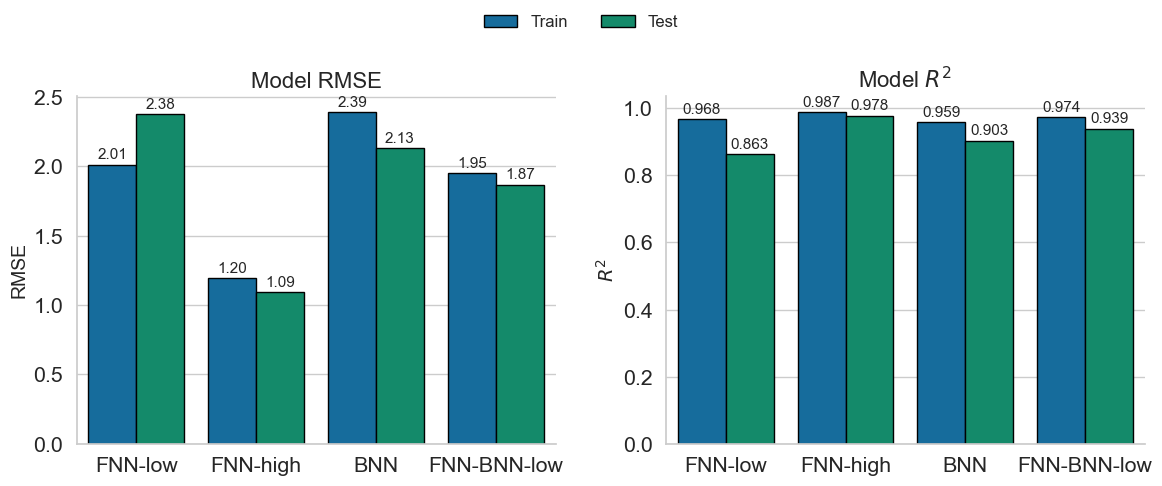

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Store results
rmse_results = []
r2_results = []

# Model list with labels and data
models_data = [
    ("FNN-low", fnn_low_data[y_cols], fnn_low_pred_train_df, test_data[y_cols], fnn_low_pred_test_df),
    ("FNN-high", fnn_high_data[y_cols], fnn_high_pred_train_df, test_data[y_cols], fnn_high_pred_test_df),
    ("BNN", bnn_data[y_cols], bnn_pred_train_df, test_data[y_cols], bnn_pred_test_df),
    ("FNN-BNN-low", fnn_bnn_data[y_cols], fnn_bnn_low_pred_train_df, test_data[y_cols], fnn_bnn_low_pred_test_df)
]

# Calculate metrics
for model_name, y_train, y_pred_train, y_test, y_pred_test in models_data:
    rmse_results.append([model_name, "Train", rmse(y_train, y_pred_train)])
    rmse_results.append([model_name, "Test", rmse(y_test, y_pred_test)])
    
    r2_results.append([model_name, "Train", r2_score(y_train, y_pred_train)])
    r2_results.append([model_name, "Test", r2_score(y_test, y_pred_test)])

# Create tidy DataFrames
df_rmse = pd.DataFrame(rmse_results, columns=["Model", "Dataset", "Value"])
df_r2 = pd.DataFrame(r2_results, columns=["Model", "Dataset", "Value"])

# Custom color palette
palette = {"Train": "#0072B2", "Test": "#009E73"}

# Figure
sns.set_theme(style="whitegrid", font_scale=1.4)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# RMSE plot
sns.barplot(data=df_rmse, x="Model", y="Value", hue="Dataset", palette=palette, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("RMSE", fontsize=14)
axes[0].set_xlabel("")
axes[0].set_title("Model RMSE", fontsize=16)

# Add value labels to each bar
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f', padding=2, fontsize=11)



# R² plot
sns.barplot(data=df_r2, x="Model", y="Value", hue="Dataset", palette=palette, edgecolor="black", ax=axes[1])
axes[1].set_ylabel(r"$R^2$", fontsize=14)
axes[1].set_xlabel("")
axes[1].set_title("Model $R^2$", fontsize=16)

# Add value labels to each bar
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.3f', padding=2, fontsize=11)

# Common legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, fontsize=12, title="", title_fontsize=12)

# Remove individual legends
axes[0].get_legend().remove()
axes[1].get_legend().remove()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.92])
sns.despine()
plt.show()
